In [3]:
import numpy as np
import tensorflow as tf
filePath = './test_case_ans/sample_case002_input.txt'
resPath = './ans'

c = 3e8

def loadData(filePath):
    with open(filePath, 'r') as fd:
        station_num = int(fd.readline())
        device_num = int(fd.readline())
        dimen = int(fd.readline())
        station_cord = []
        for i in range(station_num):
            cord = fd.readline().split()
            cord = [np.float64(i) for i in cord]
            station_cord.append(cord)
        station_cord = np.array(station_cord)

        device_cord = []
        for i in range(device_num):
            cord = fd.readline().split()
            cord = [np.float64(i) for i in cord]
            device_cord.append(cord)
        device_cord = np.array(device_cord)
        return station_cord, device_cord, dimen

def loadRes(filePath):
    with open(filePath, 'r') as fd:
        device_cord = []
        for line in fd:
            cord = [np.float64(i) for i in line.split()]
            device_cord.append(cord)
    device_cord = np.array(device_cord)
    return device_cord

    

S, D, dimen = loadData(filePath)
device_Dist = D*c

cord_init = np.mean(S, axis=0)
cord_init = cord_init.reshape([1, dimen]) * np.ones([len(D), dimen])
bias_init = np.zeros(len(D))
# cord_init = loadRes(resPath)

cut=10
device_Dist = device_Dist[:10]
cord_init = cord_init[:10]
bias_init = bias_init[:10]

with tf.device('/gpu:3'):
    #     cord_x = tf.Variable(cord_init[:, 0], name='Cordinate_x', trainable=False) #(N,)
    #     cord_y = tf.Variable(cord_init[:, 1], name='Cordinate_y', trainable=False)
    #     cord_z = tf.Variable(cord_init[:, 2], name='Cordinate_z', trainable=False)
    cord = tf.Variable(cord_init, name='Cordinate') #(N,3)
    Station = tf.constant(S, tf.float64) #(M,3)
    bias = tf.Variable(bias_init, 'Bias') #(N, )

    alpha1 = tf.Variable(np.ones(len(cord_init)), 'Alpha1', dtype = tf.float64)  #(N,)
    alpha2 = tf.Variable(np.ones(len(cord_init)), 'Alpha2', dtype = tf.float64)  #(N,)
    alpha3 = tf.Variable(np.ones(len(cord_init)), 'Alpha3', dtype = tf.float64)  #(N,)
    beta1 = tf.Variable(np.ones(len(S)), 'Beta1', dtype = tf.float64)  #(M,)

    D_dist = tf.constant(device_Dist, tf.float64)
    mask = tf.constant([[[1, 1, 1]]], tf.float64)

    expand_cord = tf.expand_dims(cord, 1) #(N, 1, 3)
    expand_Station = tf.expand_dims(Station, 0) #(1, M, 3)

    expand_alpha1 = tf.expand_dims(alpha1, 1) #(N, 1)
    expand_alpha2 = tf.expand_dims(alpha2, 1) 
    expand_alpha3 = tf.expand_dims(alpha3, 1)

    expand_beta1 = tf.expand_dims(beta1, 0)

    expand_bias = tf.expand_dims(bias, 1)

    dist_2 = tf.reduce_sum(mask * (expand_cord - expand_Station)**2, 2) #(N, M)

    global_step = tf.Variable(0, name='global_step', trainable=False)


    # dist_hat = tf.sqrt(expand_alpha1**2 * dist_x +expand_alpha2**2 * dist_y +
    #                    expand_alpha3**2 * dist_z) - expand_bias #(N,M)
    # dist_hat = expand_alpha1 * tf.sqrt(dist_x + dist_y + expand_alpha2**2) - expand_bias #(N,M)
    dist_hat = expand_alpha1**2 * tf.sqrt(dist_2) - expand_bias  #(N,M)

    losses = tf.reduce_sum((dist_hat - D_dist) **2, 1)
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.85, staircase=True) + tf.train.exponential_decay(1e-2, global_step, 5000, 0.85, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(losses, global_step=global_step)

config=tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
# with tf.Session(config=config) as sess:
sess = tf.Session(config=config)
sess.run(tf.initialize_all_variables())
for i in range(30000):
    _, loss = sess.run([train_op, losses])
    if i%1000 == 0:
        print np.sum(loss), 'lr=', sess.run(learning_rate)
B, P, a1 = sess.run([bias, cord, alpha1])

with open(resPath, 'w') as fd:
    for i in range(len(P)):
        fd.write('{}\t{}\t{}\n'.format(P[i, 0], P[i, 1], P[i, 2]))

24123554.2784 lr= 0.51
234720.13856 lr= 0.41
103682.605946 lr= 0.33
6151.54062761 lr= 0.266
412.607302579 lr= 0.2148
4103.09511575 lr= 0.17184
49.3007926611 lr= 0.139072
38.2624975748 lr= 0.112858
45.9078110412 lr= 0.0918861
72.2321609942 lr= 0.0751089
213.778090627 lr= 0.0600871
32.009664582 lr= 0.0493497
31.7839687471 lr= 0.0407597
31.3271979349 lr= 0.0338878
31.1446088565 lr= 0.0283902
30.970640327 lr= 0.0227122
31.1379160225 lr= 0.0191938
30.8560693746 lr= 0.016379
30.8097158524 lr= 0.0141272
30.7801049856 lr= 0.0123258
30.8480556213 lr= 0.00986061
30.9814650965 lr= 0.00870769
298.350435689 lr= 0.00778535
30.6766830274 lr= 0.00704748
84.1402956402 lr= 0.00645718
30.9136582097 lr= 0.00516575
31.8319888241 lr= 0.00478796
30.6236005963 lr= 0.00448573
33.7483832797 lr= 0.00424394
30.612654967 lr= 0.00405051


In [40]:
with open(resPath, 'w') as fd:
    for i in range(len(P)):
        fd.write('{}\t{}\t{}\n'.format(P[i, 0], P[i, 1], P[i, 2]))

In [4]:
print P[0:20]
print '-------'
print B[:20]
print '-------'
print a1[:20]

[[-259.16161947 -341.62543453    6.4787383 ]
 [ 304.91133218 -277.04609176    7.03689454]
 [ 332.7612318  -223.27388972    1.34598805]
 [ 165.89849855 -235.64387821    6.25997444]
 [-293.18950242  230.74580563   -1.37130481]
 [-103.48382982   11.1798967    -3.80573188]
 [ -32.55587981 -261.15533628  -11.79109874]
 [-249.36674162  153.47939773   -4.89991291]
 [-200.54630666  279.1750526     1.49001231]
 [ 198.15621192  263.46783407    1.01954178]]
-------
[-0.68746879 -0.37453208 -0.50044442 -0.37627352 -0.42295982  0.00109399
  0.40050723 -0.04793405 -0.41443034 -0.53620865]
-------
[ 1.0149729   1.01458959  1.01502038  1.01505794  1.01512379  1.01549051
  1.0153905   1.01527397  1.01502339  1.01501244]


In [36]:
print P[0:20]
print '-------'
print B[:20]
print '-------'
print a1[:20]

[[-259.14646    -341.60497335   -1.43777933]
 [ 304.90715039 -277.04664237    0.46952899]
 [ 332.76162136 -223.27416039    1.29782374]
 [ 165.90560382 -235.64786729    2.88507879]
 [-293.18977001  230.74604187   -1.37254098]
 [-103.48380349   11.17988391   -3.80862539]
 [ -32.55351307 -261.15921007  -12.25029773]
 [-249.36703464  153.47964607   -4.90921003]
 [-200.54648143  279.17529825    1.47844776]
 [ 198.15621194  263.4678525     1.01869785]]
-------
[-0.67699688 -0.39960972 -0.49926608 -0.4224683  -0.4226125   0.00138202
  0.45067491 -0.04702113 -0.41401752 -0.53613238]
-------
[ 1.03019963  1.02994032  1.03026763  1.03025619  1.03047635  1.0312216
  1.03108219  1.03078126  1.03027241  1.03025034]


In [5]:
print np.random.rand(3)*10

[ 4.8625388   8.20855339  4.87781797]


In [41]:
%%bash
head  test_case_ans/sample_case002_input.txt

40
1200
3
299.46	335.64	3.77	
201.41	167.37	4.70	
-303.59	-333.12	2.36	
36.52	118.45	3.82	
-294.49	208.39	2.77	
367.06	-294.69	3.55	
249.87	-144.93	3.81	


ValueError: too many values to unpack

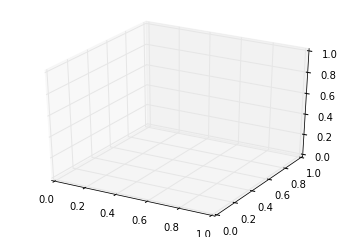

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xx = [184.09,4.81,-309.31,141.17,140.54,220.92,94.26,361.48,329.07,-369.38,-87.66,-211.33,284.39,-146.34,-105.77,68.78,-237.09,-217.3,-344.19,67.27,339.72,103.32,97.79,-143.63,113.34,188.09,30.99,210.23,137.72,136.44,344.61,-82.62,72.91,-242.69,-248.4,214.66,391.68,40.25,393.12,-414.89,-306.3,-422.18,-319.95,-120.92,202.47,177,272.93,-254.17,-296.88,249.7,259.82,-95.93,54.85,295.8,-259.81,-208.81,-56.32,-105.6,-173.47,82.1]
yy = [211.82,316.75,-222.58,348.05,-4.93,-40.3,296.06,-164.46,-50.84,144.81,-119.38,-251.12,50.05,391.94,219.84,163.56,-251.87,-71.1,199.94,-269.07,89.86,335.62,116.38,-291.76,393.35,224.97,379.25,234.7,-1.96,-392.5,-364.62,203.64,-261.42,417.05,161.01,-287.85,-269.81,-248.59,-56.26,-97.15,-184.78,332.53,-328.02,-87.47,80.93,183.24,27.83,248.02,-41.58,104.39,-135.9,-196.86,130.07,-387.19,370.37,114.59,99.98,167.08,-116.02,391.22]
zz = [3.81,3.58,4.73,2.81,4.48,3.25,2.25,4.71,2.35,2.25,4.8,2.38,2.13,2.15,4.55,2.66,4.67,2.42,4.41,2.39,4.68,3.92,3.15,2.89,4.82,3.76,3.28,3.62,3.36,2.46,3.06,4.29,2.65,4.32,2.26,4.26,3.25,3.45,4.59,3.89,2.1,3.42,3.76,2.87,4.39,3.48,2.37,4.4,4.05,4.15,3.09,3.79,2.01,2.58,3.3,4.79,2.15,2.43,4.89,3.67]
aa, bb, cc = np.meshgrid(xx, yy, zz)

ax.plot_surface(aa, bb, cc, rstride=4, cstride=4, color='b')
plt.show()

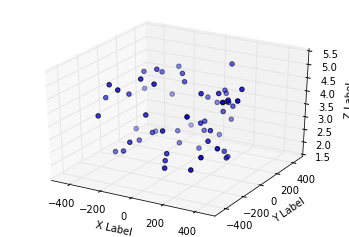

In [31]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


def randrange(n, vmin, vmax):
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
n = 100
xx = [184.09,4.81,-309.31,141.17,140.54,220.92,94.26,361.48,329.07,-369.38,-87.66,-211.33,284.39,-146.34,-105.77,68.78,-237.09,-217.3,-344.19,67.27,339.72,103.32,97.79,-143.63,113.34,188.09,30.99,210.23,137.72,136.44,344.61,-82.62,72.91,-242.69,-248.4,214.66,391.68,40.25,393.12,-414.89,-306.3,-422.18,-319.95,-120.92,202.47,177,272.93,-254.17,-296.88,249.7,259.82,-95.93,54.85,295.8,-259.81,-208.81,-56.32,-105.6,-173.47,82.1]
yy = [211.82,316.75,-222.58,348.05,-4.93,-40.3,296.06,-164.46,-50.84,144.81,-119.38,-251.12,50.05,391.94,219.84,163.56,-251.87,-71.1,199.94,-269.07,89.86,335.62,116.38,-291.76,393.35,224.97,379.25,234.7,-1.96,-392.5,-364.62,203.64,-261.42,417.05,161.01,-287.85,-269.81,-248.59,-56.26,-97.15,-184.78,332.53,-328.02,-87.47,80.93,183.24,27.83,248.02,-41.58,104.39,-135.9,-196.86,130.07,-387.19,370.37,114.59,99.98,167.08,-116.02,391.22]
zz = [3.81,3.58,4.73,2.81,4.48,3.25,2.25,4.71,2.35,2.25,4.8,2.38,2.13,2.15,4.55,2.66,4.67,2.42,4.41,2.39,4.68,3.92,3.15,2.89,4.82,3.76,3.28,3.62,3.36,2.46,3.06,4.29,2.65,4.32,2.26,4.26,3.25,3.45,4.59,3.89,2.1,3.42,3.76,2.87,4.39,3.48,2.37,4.4,4.05,4.15,3.09,3.79,2.01,2.58,3.3,4.79,2.15,2.43,4.89,3.67]


ax.scatter(xx, yy, zz)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

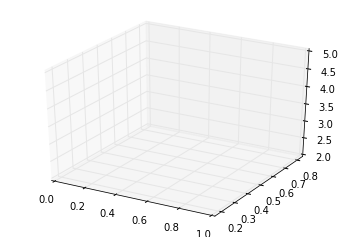

In [38]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

n_angles = 36
n_radii = 8

# An array of radii
# Does not include radius r=0, this is to eliminate duplicate points
radii = np.linspace(0.125, 1.0, n_radii)

# An array of angles
angles = np.linspace(0, 2*np.pi, n_angles, endpoint=False)

# Repeat all angles for each radius
angles = np.repeat(angles[..., np.newaxis], n_radii, axis=1)

# Convert polar (radii, angles) coords to cartesian (x, y) coords
# (0, 0) is added here. There are no duplicate points in the (x, y) plane
x = np.append(0, (radii*np.cos(angles)).flatten())
y = np.append(0, (radii*np.sin(angles)).flatten())

# Pringle surface
z = np.sin(-x*y)

fig = plt.figure()
ax = fig.gca(projection='3d')
xx = [184.09,4.81,-309.31,141.17,140.54,220.92,94.26,361.48,329.07,-369.38,-87.66,-211.33,284.39,-146.34,-105.77,68.78,-237.09,-217.3,-344.19,67.27,339.72,103.32,97.79,-143.63,113.34,188.09,30.99,210.23,137.72,136.44,344.61,-82.62,72.91,-242.69,-248.4,214.66,391.68,40.25,393.12,-414.89,-306.3,-422.18,-319.95,-120.92,202.47,177,272.93,-254.17,-296.88,249.7,259.82,-95.93,54.85,295.8,-259.81,-208.81,-56.32,-105.6,-173.47,82.1]
yy = [211.82,316.75,-222.58,348.05,-4.93,-40.3,296.06,-164.46,-50.84,144.81,-119.38,-251.12,50.05,391.94,219.84,163.56,-251.87,-71.1,199.94,-269.07,89.86,335.62,116.38,-291.76,393.35,224.97,379.25,234.7,-1.96,-392.5,-364.62,203.64,-261.42,417.05,161.01,-287.85,-269.81,-248.59,-56.26,-97.15,-184.78,332.53,-328.02,-87.47,80.93,183.24,27.83,248.02,-41.58,104.39,-135.9,-196.86,130.07,-387.19,370.37,114.59,99.98,167.08,-116.02,391.22]
zz = [3.81,3.58,4.73,2.81,4.48,3.25,2.25,4.71,2.35,2.25,4.8,2.38,2.13,2.15,4.55,2.66,4.67,2.42,4.41,2.39,4.68,3.92,3.15,2.89,4.82,3.76,3.28,3.62,3.36,2.46,3.06,4.29,2.65,4.32,2.26,4.26,3.25,3.45,4.59,3.89,2.1,3.42,3.76,2.87,4.39,3.48,2.37,4.4,4.05,4.15,3.09,3.79,2.01,2.58,3.3,4.79,2.15,2.43,4.89,3.67]

plt.axis('equal')
ax.plot_trisurf(xx, yy, zz, cmap=cm.jet, linewidth=0.2)

plt.show()
